5та лабораториска вежба по предметот Податочно рударство

Изработиле: Јана Митровска (181080) и Бојан Петрушевски (162012)

Тема: Linear regression, Lasso, Ridge

# **Reading the Dataset**

In [ ]:
import pandas as pd
import numpy as np
import sklearn 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from scipy import stats
from operator import sub
from sklearn import metrics
from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score, cross_validate, GridSearchCV, KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_roc_curve, classification_report, confusion_matrix, mean_squared_error, r2_score
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/netflix.csv')

In [ ]:
data.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,Unknown,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,14-Aug-20,2020,TV-MA,4,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,23-Dec-16,2016,TV-MA,93,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,20-Dec-18,2011,R,78,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,16-Nov-17,2009,PG-13,80,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,1-Jan-20,2008,PG-13,123,Dramas,A brilliant group of students become card-coun...


# **Building the Model**

In [ ]:
data_encoded = data.apply(LabelEncoder().fit_transform)

In [ ]:
data_encoded

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,0,1,83,3748,3160,6,328,71,8,3,398,3912
1,1111,0,125,1789,1589,42,844,67,8,91,310,1390
2,2222,0,68,1253,6200,60,707,62,5,76,336,7172
3,3333,0,127,3355,1788,75,476,60,4,78,47,3936
4,4444,0,61,3095,2924,75,97,59,4,121,294,138
...,...,...,...,...,...,...,...,...,...,...,...,...
7782,7537,0,7759,1793,2487,67,635,56,8,97,310,6876
7783,7538,0,7761,2536,6474,28,675,66,6,109,312,889
7784,7539,0,7762,3748,4601,76,985,70,8,42,269,4197
7785,7540,1,7763,3748,140,1,1286,70,9,0,368,2823


In [ ]:
X = data_encoded.drop(['duration'], axis = 1)
Y = data_encoded.duration.values

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2)

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# **Linear Regression**

In [ ]:
model = LinearRegression().fit(X_train, Y_train)

In [ ]:
coeff_df = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
coeff_df

,Coefficient
show_id,0.147648
type,-41.191243
title,0.589898
director,-0.622872
cast,-0.977660
country,-5.431202
date_added,-0.304475
release_year,-3.487958
rating,-4.735766
listed_in,-1.687057


In [ ]:
y_pred = model.predict(X_test)

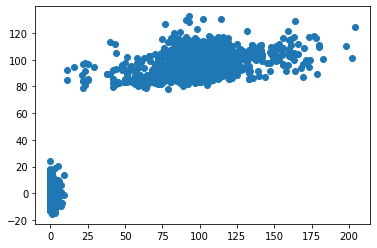

In [ ]:
plt.scatter(Y_test, y_pred)

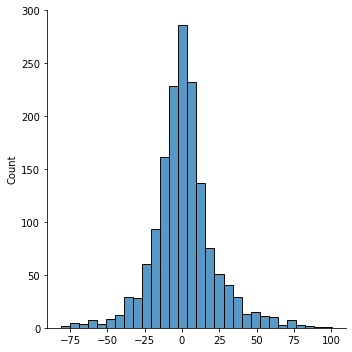

In [ ]:
sns.displot((Y_test - y_pred), bins=30)

In [ ]:
print('MAE: ', metrics.mean_absolute_error(Y_test, y_pred))
print('MSE: ', metrics.mean_squared_error(Y_test, y_pred))
print('RMSE: ', np.sqrt(metrics.mean_squared_error(Y_test, y_pred)))

MAE:  14.5028031814667
MSE:  440.1233159713813
RMSE:  20.979116186612373


In [ ]:
r_sq = model.score(X_train, Y_train)
print('coefficient of determination:', r_sq)

coefficient of determination: 0.8104827857834412


In [ ]:
np.set_printoptions(formatter={'float_kind':'{:2f}'.format})

In [ ]:
X = data_encoded.rating.values
Y = data_encoded.duration.values

In [ ]:
poly = PolynomialFeatures(3, include_bias=False)
x_np = np.array(X)
poly.fit_transform(x_np[:, None])

array([[8.000000, 64.000000, 512.000000],
       [8.000000, 64.000000, 512.000000],
       [5.000000, 25.000000, 125.000000],
       ...,
       [8.000000, 64.000000, 512.000000],
       [9.000000, 81.000000, 729.000000],
       [8.000000, 64.000000, 512.000000]])

In [ ]:
poly_model = make_pipeline(PolynomialFeatures(8), LinearRegression())
X = np.array(X)
poly_model.fit(X[:, np.newaxis], Y)

xfit = np.linspace(min(X), max(X), 1000)
yfit = poly_model.predict(xfit[:, np.newaxis])

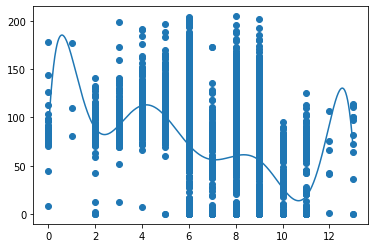

In [ ]:
plt.scatter(X, Y)
plt.plot(xfit, yfit)

# **Lasso**

In [ ]:
model = Lasso(alpha=0.0001)
model.fit(X[:, np.newaxis],Y)

Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [ ]:
print(model.intercept_)

131.52572452170847


In [ ]:
yfit = model.predict(xfit[:, np.newaxis])

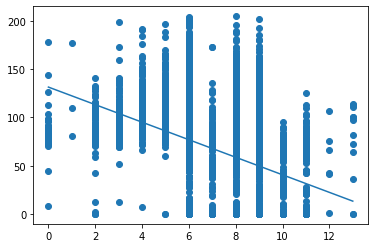

In [ ]:
plt.scatter(X, Y)
plt.plot(xfit, yfit)

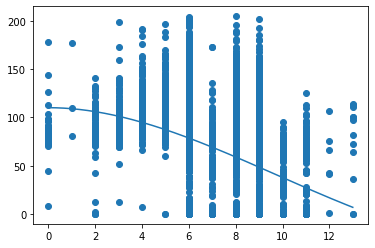

In [ ]:
poly_model = make_pipeline(PolynomialFeatures(3), Lasso(alpha=1))
X = np.array(X)
poly_model.fit(X[:, np.newaxis], Y)
yfit = poly_model.predict(xfit[:, np.newaxis])
plt.scatter(X, Y)
plt.plot(xfit, yfit)

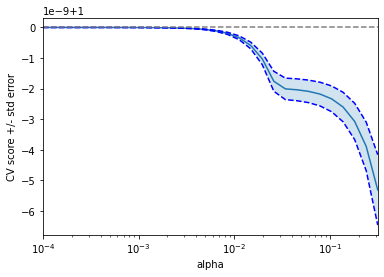

In [ ]:
X = data_encoded[:150]
Y = data_encoded[:150]

lasso = Lasso(random_state=0, max_iter=10000)
alphas = np.logspace(-4, -0.5, 30)

tuned_parametars = [{'alpha': alphas}]
n_folds = 5

clf = GridSearchCV(lasso, tuned_parametars, cv=n_folds, refit=False)
clf.fit(X,Y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']
plt.semilogx(alphas, scores)

std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])
plt.show()

# **Ridge**

In [ ]:
X = data_encoded.rating.values
Y = data_encoded.duration.values

In [ ]:
model = Ridge(alpha=0.001)
model.fit(X[:, np.newaxis], Y)

Ridge(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [ ]:
print(model.intercept_)

131.52590754029157


In [ ]:
yfit = model.predict(xfit[:, np.newaxis])

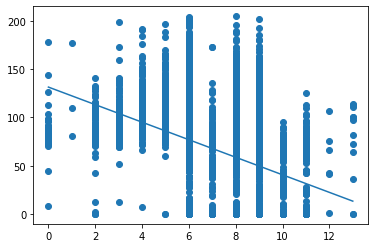

In [ ]:
plt.scatter(X, Y)
plt.plot(xfit, yfit)

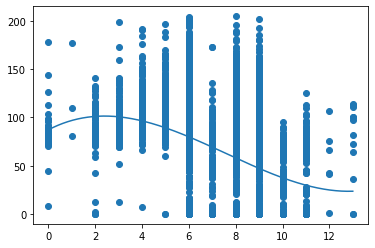

In [ ]:
poly_model = make_pipeline(PolynomialFeatures(3), Ridge(alpha=0.001))
X = np.array(X)
poly_model.fit(X[:, np.newaxis], Y)
yfit = poly_model.predict(xfit[:, np.newaxis])
plt.scatter(X, Y)
plt.plot(xfit, yfit)